## The model:
$$
dS(t) = S(t) \cdot \left( \mu \, dt + \sigma \, dW(t) + (J - 1) \, dN(t) \right)
$$
where
1) $W(t)$: Standard Brownian motion
2) $N(t)$: Poisson process with intensity $\lambda$ (average number of jumps per unit time)
3) $J$: Jump multiplier such that the price after a jump is $S(t) \cdot J$, $J=e^Y$ where $Y = \mathcal{N}(\mu_J,\sigma^2_J)$
4) $\mu$: Drift term
5) $\sigma$: Volatility of the continuous component

Let $X(t) = \mathrm{ln}(S(t))$, it can be written as
$$
X(t) = \ln S(0) + \left(\mu - \frac{\sigma^2}{2} - \lambda \mathbb{E}[J - 1]\right) t + \sigma W(t) + \sum_{i=1}^{N(t)} Y_i,
$$
where
1) $N(\Delta t)$∼Poisson($\lambda \Delta t$) is the number of jumps in $\Delta t$
2) Each jump $Y_i$ ~ $\mathcal{N}(\mu_J,\sigma^2_J)$

The solution can be written as
$$
S(t) = S(0) \cdot \exp\left[\left(\mu - \frac{\sigma^2}{2} - \lambda \mathbb{E}[J - 1]\right) t + \sigma W(t) + \sum_{i=1}^{N(t)} Y_i\right].
$$

The log-return is then
$$
r(t) = \left(\mu - \frac{\sigma^2}{2} - \lambda \mathbb{E}[J - 1]\right) \Delta t 
       + \sigma \Delta W + \sum_{i=1}^{N(\Delta t)} Y_i.
$$
By FTing the log-return, one can define the PDF as

$$
p(r) = e^{-\lambda \Delta t} \cdot \mathcal{N}(r \mid \mu_r, \sigma_r^2) 
       + \sum_{k=1}^\infty \frac{(\lambda \Delta t)^k}{k!} \cdot \mathcal{N}(r \mid \mu_r + k \mu_J, \sigma_r^2 + k \sigma_J^2),
$$
where
1) $\mu_r = \left( \mu -\frac{\sigma^2}{2}-\lambda \mathbb{E}[J - 1] \right) \Delta t $
2) $\sigma_r^2 = \sigma^2 \Delta t $
3) $\mathbb{E}[J - 1] = e^{\mu_J + \sigma^2_J/2}$

which we can make use of the Normal distribution.

Note there is an infinite sum which cannot be simplified, one pritical way is to truncated at $k_\mathrm{max}$ which we will set to 20 (which should be a pretty good choice for any time frame under daily rate).

$$
p(r) \approx e^{-\lambda \Delta t} \cdot \mathcal{N}(r \mid \mu_r, \sigma_r^2) 
       + \sum_{k=1}^{20} \frac{(\lambda \Delta t)^k}{k!} \cdot \mathcal{N}(r \mid \mu_r + k \mu_J, \sigma_r^2 + k \sigma_J^2)
$$

In [127]:
import numpy as np
import pandas as pd
import pytensor.tensor as pt
from pytensor.tensor import TensorVariable
import arviz as az

import pymc as pm
from scipy.stats import norm

import yfinance as yf
import pandas_datareader as pdr

from datetime import datetime, timedelta

import matplotlib.pyplot as plt

You can choose whatever ticker you want

In [80]:
df = yf.download(tickers='TSLA',start='2020-01-01')
Log_return = np.log(df['Close']/df['Close'].shift(1)).dropna()

[*********************100%%**********************]  1 of 1 completed


In [211]:
def jump_diffusion_logp(r, mu, sigma, lambda_, mu_J, sigma_J, delta_t, K=20):

    r = pt.as_tensor_variable(r)
    
    E_J_minus_1 = pt.exp(mu_J + sigma_J**2/2) - 1
    mu_r = (mu - sigma**2/2 - lambda_ * E_J_minus_1) * delta_t
    sigma_r_sq = sigma**2 * delta_t
    
    # Base component (k=0)
    log_first_term = -lambda_ * delta_t - \
                     0.5 * pt.log(2 * np.pi * sigma_r_sq) - \
                     0.5 * ((r - mu_r)**2) / sigma_r_sq
    
    # Initialize accumulator for jump terms
    k_sum = pt.zeros_like(r)
    
    # Compute jump terms in batches to reduce nesting
    for k in range(1, K+1):
        k_mu = mu_r + k*mu_J
        k_var = sigma_r_sq + k*sigma_J**2
        
        log_k_term = k * pt.log(lambda_ * delta_t) - \
                     pt.gammaln(k+1) - \
                     0.5 * pt.log(2 * np.pi * k_var) - \
                     0.5 * ((r - k_mu)**2) / k_var
        
        k_sum = k_sum + pt.exp(log_k_term)
    
    return pt.log(pt.exp(log_first_term) + k_sum + 1e-10)

def fit_jump_diffusion(returns, delta_t=1/252):

    returns = np.array(returns, dtype='float64')
    
    with pm.Model() as model:
        # Priors
        mu = pm.Normal('mu', mu=0, sigma=1)
        sigma = pm.HalfNormal('sigma', sigma=0.5)
        lambda_ = pm.HalfNormal('lambda', sigma=3)
        mu_J = pm.Normal('mu_J', mu=0, sigma=0.05)
        sigma_J = pm.HalfNormal('sigma_J', sigma=0.05)
        
        # Log likelihood
        pm.Potential('likelihood', 
                    pt.sum(jump_diffusion_logp(returns, 
                                             mu, sigma, lambda_,
                                             mu_J, sigma_J, 
                                             delta_t)))
        
        # Sampling with reduced iterations
        trace = pm.sample(2000,
                         tune=800,
                         cores=4,
                         return_inferencedata=True,
                         init='adapt_diag',
                         target_accept=0.95)
    
    return trace

In [213]:
Para = fit_jump_diffusion(Log_return)

Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, lambda, mu_J, sigma_J]


Output()

Sampling 4 chains for 800 tune and 2_000 draw iterations (3_200 + 8_000 draws total) took 44 seconds.


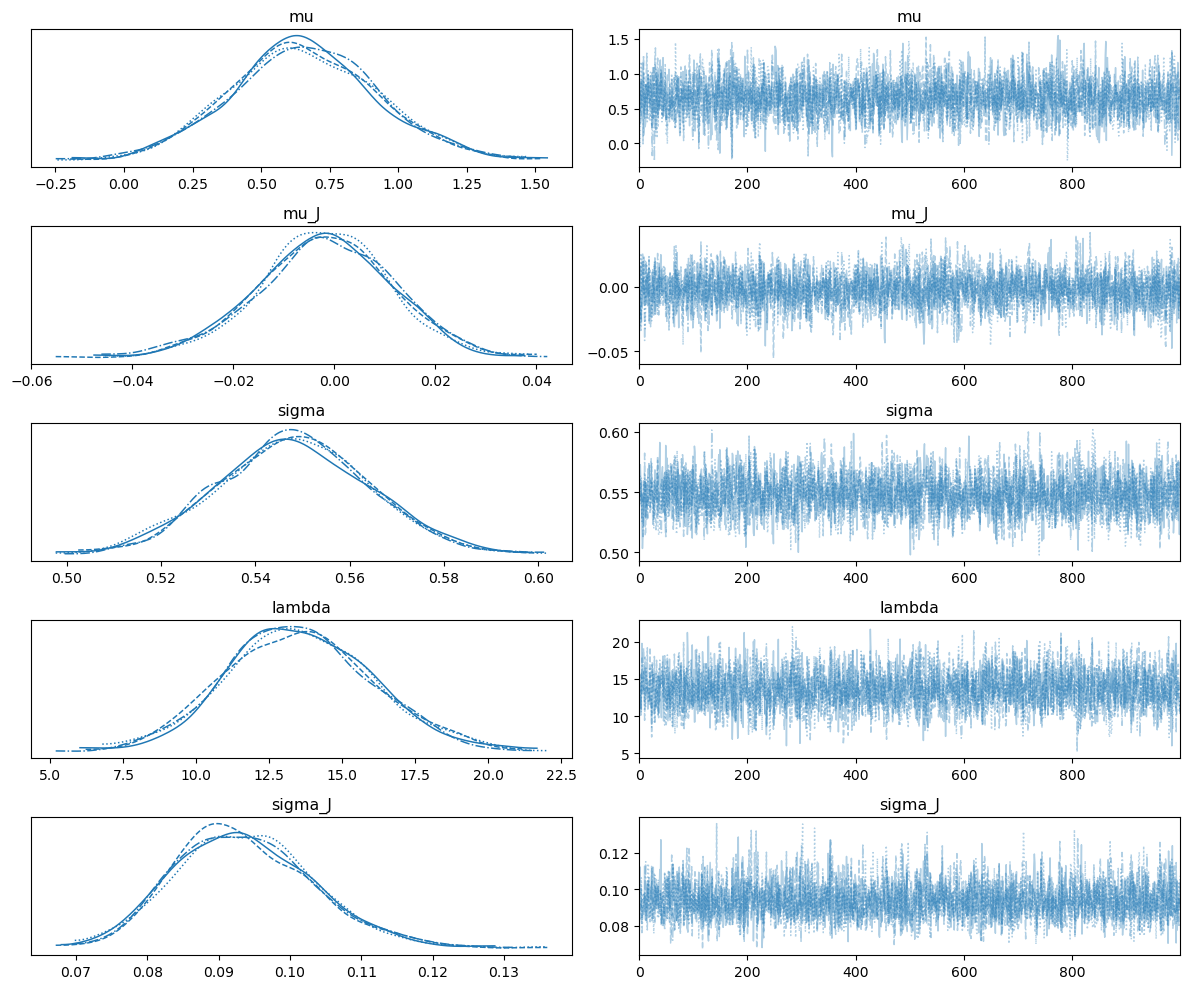

            mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd   ess_bulk  \
mu        0.6561  0.2703  0.1594   1.1762     0.0047   0.0035  3286.7950   
mu_J     -0.0020  0.0134 -0.0285   0.0223     0.0002   0.0002  3158.2921   
sigma     0.5482  0.0161  0.5180   0.5787     0.0003   0.0002  2744.9265   
lambda   13.5501  2.5032  8.8634  18.4330     0.0471   0.0333  2794.1049   
sigma_J   0.0938  0.0099  0.0768   0.1135     0.0002   0.0001  3276.5713   

          ess_tail   r_hat  
mu       2555.8264  0.9999  
mu_J     2633.3650  1.0007  
sigma    2982.5520  1.0003  
lambda   2452.0020  1.0011  
sigma_J  2916.6580  1.0002  


In [214]:
az.plot_trace(Result)
plt.tight_layout()
plt.show()
print(az.summary(Result, round_to=4))

The option price for the MJD model is related to the Black-Scholes, using the risk-free-rate to perform the risk-neutral measure $\mathcal{Q}$ to adjust the drift term.

For call

$$
C(S, T) = e^{-\lambda T} \cdot C_{\text{BS}}(S, T, r, \sigma) 
          + \sum_{k=1}^\infty \frac{(\lambda T)^k}{k!} e^{-\lambda T} \cdot C_{\text{BS}}\left(S, T, r, \sqrt{\sigma^2 + \frac{k \sigma_J^2}{T}}, \ln S + k \mu_J\right)
$$
where
$$
C_{\text{BS}}(S, T, r, \sigma) = S \cdot N(d_1) - K \cdot e^{-rT} \cdot N(d_2)
$$

For put

$$
P(S, T) = e^{-\lambda T} \cdot P_{\text{BS}}(S, T, r, \sigma) 
          + \sum_{k=1}^\infty \frac{(\lambda T)^k}{k!} e^{-\lambda T} \cdot P_{\text{BS}}\left(S, T, r, \sqrt{\sigma^2 + \frac{k \sigma_J^2}{T}}, \ln S + k \mu_J\right)
$$
where
$$
P_{\text{BS}}(S, T, r, \sigma) = K \cdot e^{-rT} \cdot N(-d_2) - S \cdot N(-d_1)
$$

and
$$
d_1 = \frac{\ln(S / K) + \left(r + \frac{\sigma^2}{2}\right)T}{\sigma \sqrt{T}}, \quad
d_2 = d_1 - \sigma \sqrt{T}.
$$

similarly we are going to truncate the sum at 20

In [220]:
def black_scholes(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    call = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    put = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    
    return call, put

def merton_jump_diffusion(S, K, T, r, sigma, lam, mu_J, sigma_J, k_max=20):
    call_price = 0.0
    put_price = 0.0
    
    for k in range(k_max + 1):
        # Poisson weight
        poisson_weight = np.exp(-lam * T) * (lam * T)**k / np.math.factorial(k)
        
        # Adjust volatility and mean for k jumps
        adj_sigma = np.sqrt(sigma**2 + k * sigma_J**2 / T)
        adj_lnS = np.log(S) + k * mu_J
        
        # Black-Scholes prices for this k
        bs_call, bs_put = black_scholes(np.exp(adj_lnS), K, T, r, adj_sigma)
        
        call_price += poisson_weight * bs_call
        put_price += poisson_weight * bs_put
        
    return call_price, put_price

def Get_rfr():
    from datetime import datetime, timedelta
    today = datetime.now()
    risk_free_rate = pd.DataFrame()
    shifted_date = 1
    while risk_free_rate.empty:
        risk_free_rate = pdr.DataReader('DGS3MO', 'fred', today - timedelta(days=shifted_date)).dropna()
        shifted_date += 1
    return risk_free_rate.values[0][0]/100

In [222]:
def plot_option_prices(S, K_range, T, Para, r):
    """
    Plot option prices for different strike prices using PyMC inference data.
    """
    # Extract posterior means
    posterior_means = az.summary(Para)['mean']
    
    calls_merton = []
    puts_merton = []
    calls_bs = []
    puts_bs = []
    
    for K in K_range:
        # Merton Jump Diffusion prices
        c_m, p_m = merton_jump_diffusion(S, K, T, r, 
                                       posterior_means['sigma'],
                                       posterior_means['lambda'],
                                       posterior_means['mu_J'],
                                       posterior_means['sigma_J'])
        calls_merton.append(c_m)
        puts_merton.append(p_m)
        
        # Black-Scholes prices
        c_bs, p_bs = black_scholes(S, K, T, r, posterior_means['sigma'])
        calls_bs.append(c_bs)
        puts_bs.append(p_bs)
    
    plt.figure(figsize=(15, 6))
    
    # Call options
    plt.subplot(1, 2, 1)
    plt.plot(K_range, calls_merton, 'b-', label='Merton JD Call')
    plt.plot(K_range, calls_bs, 'r--', label='Black-Scholes Call')
    plt.axvline(x=S,color='green',linestyle='--',label='Spot')
    plt.xlabel('Strike Price')
    plt.ylabel('Option Price')
    plt.title('Call Option Prices')
    plt.legend()
    plt.grid(True)
    
    # Put options
    plt.subplot(1, 2, 2)
    plt.plot(K_range, puts_merton, 'b-', label='Merton JD Put')
    plt.plot(K_range, puts_bs, 'r--', label='Black-Scholes Put')
    plt.axvline(x=S,color='green',linestyle='--',label='Spot')
    plt.xlabel('Strike Price')
    plt.ylabel('Option Price')
    plt.title('Put Option Prices')
    plt.legend()
    plt.grid(True)
    
    
    plt.tight_layout()
    plt.show()

In [224]:
S0 = df['Close'].iloc[-1]

r = Get_rfr()

K_range = np.linspace(0.7 * S0, 1.3 * S0, 100)

maturities = [1/365, 1/52, 1/12, 1/4]  # 1 day, 1 week, 1 month, 3 months

# Create results DataFrame using posterior means
posterior_means = az.summary(Para)['mean']

results = []
for T in maturities:
    for K in [0.9 * S0, S0, 1.1 * S0]:  # ATM, ITM, OTM options
        call_merton, put_merton = merton_jump_diffusion(
            S0, K, T, r,
            posterior_means['sigma'],
            posterior_means['lambda'],
            posterior_means['mu_J'],
            posterior_means['sigma_J']
        )
        
        call_bs, put_bs = black_scholes(S0, K, T, r, posterior_means['sigma'])
        
        results.append({
            'Maturity (years)': T,
            'Strike': K,
            'Moneyness': K/S0,
            'Merton Call': call_merton,
            'Merton Put': put_merton,
            'BS Call': call_bs,
            'BS Put': put_bs,
            'Call Difference': call_merton - call_bs,
            'Put Difference': put_merton - put_bs
        })

results_df = pd.DataFrame(results)

/var/folders/8d/cgrbd3xs3m97xzpgj1zs6j1m0000gn/T/ipykernel_8300/1361803505.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  poisson_weight = np.exp(-lam * T) * (lam * T)**k / np.math.factorial(k)


/var/folders/8d/cgrbd3xs3m97xzpgj1zs6j1m0000gn/T/ipykernel_8300/1361803505.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  poisson_weight = np.exp(-lam * T) * (lam * T)**k / np.math.factorial(k)



Plotting option prices for 1-week maturity...


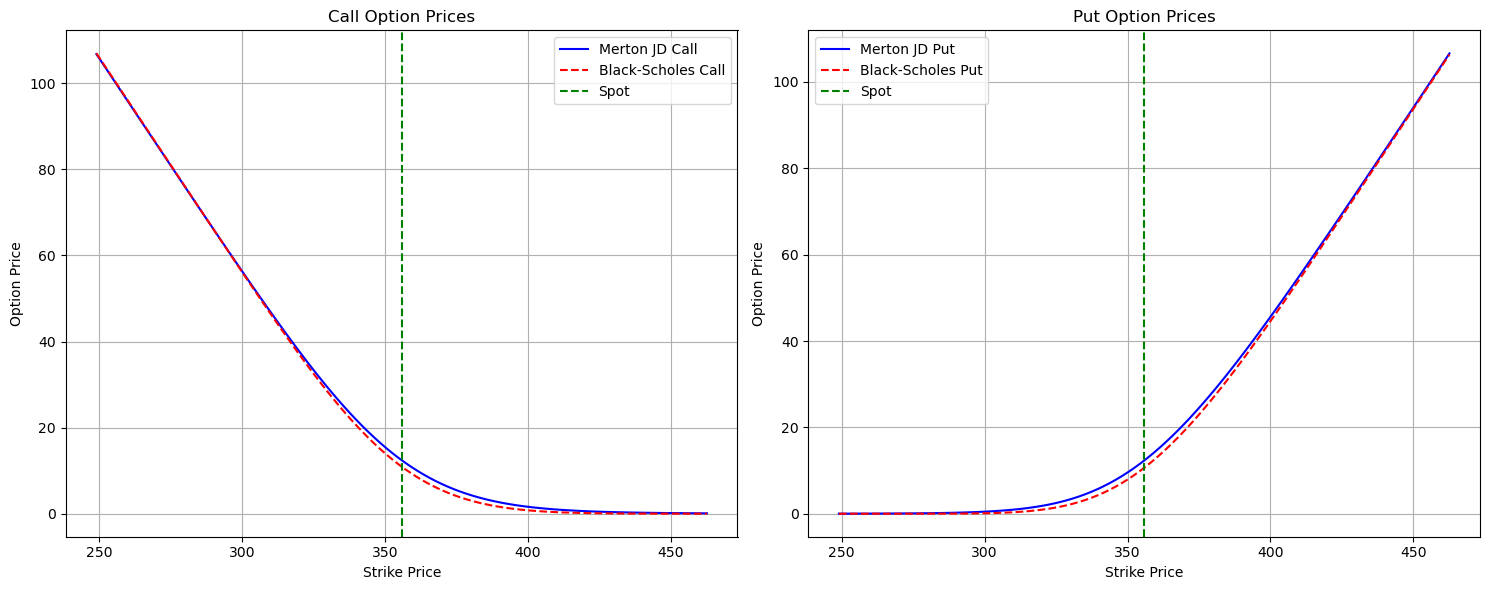

In [225]:
print("\nPlotting option prices for 1-week maturity...")
plot_option_prices(S0, K_range, 1/52, Para, r)

/var/folders/8d/cgrbd3xs3m97xzpgj1zs6j1m0000gn/T/ipykernel_8300/1361803505.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  poisson_weight = np.exp(-lam * T) * (lam * T)**k / np.math.factorial(k)


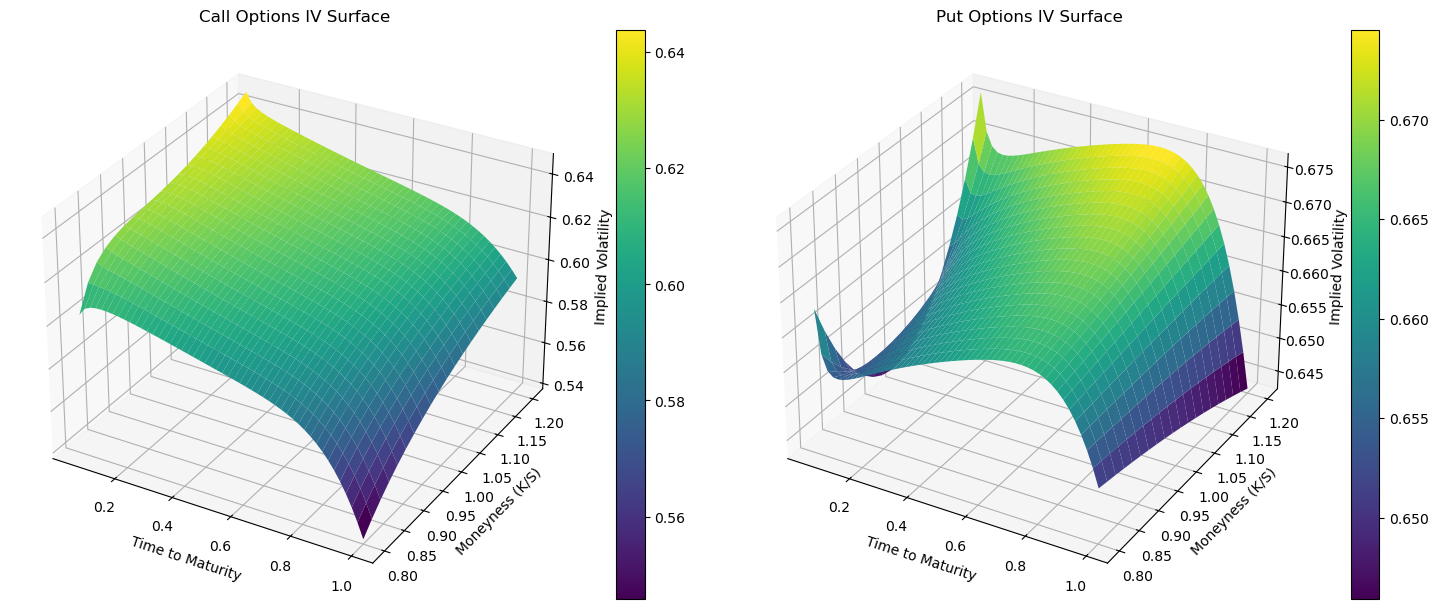

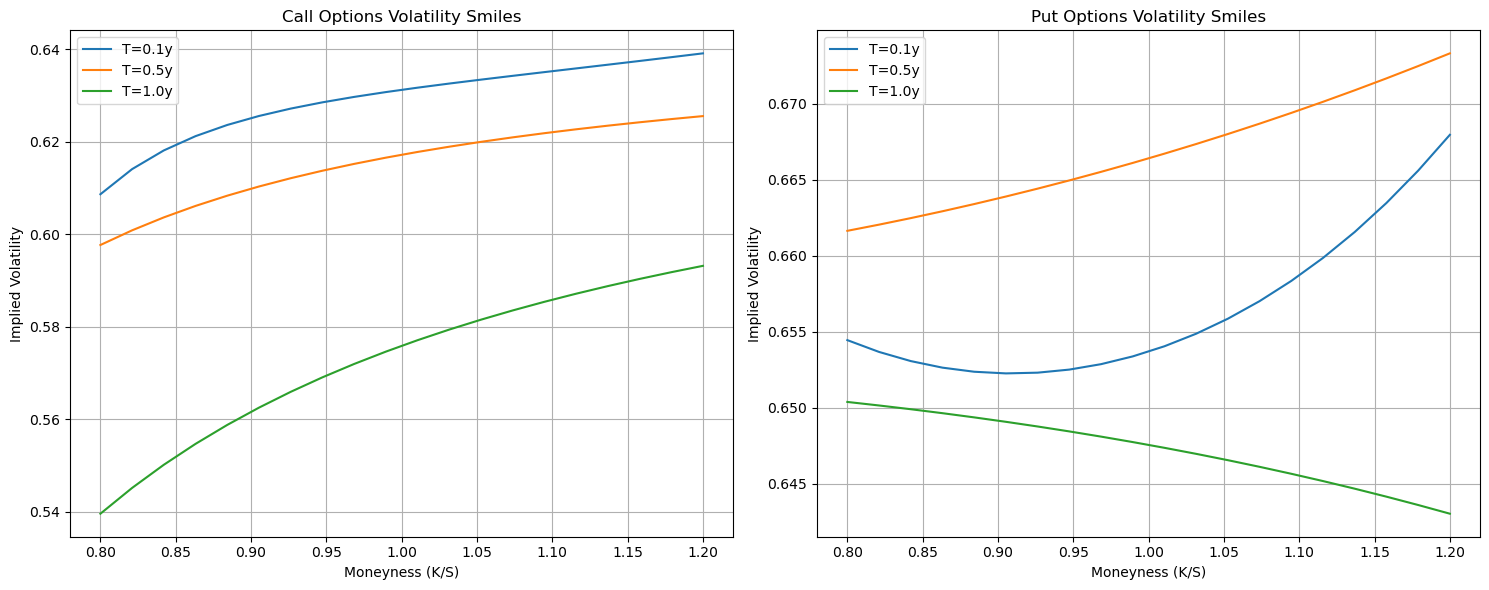

In [226]:
def calculate_iv_surface(Para, S0, r):
    posterior_means = az.summary(Para)['mean']
    strikes = np.linspace(0.8 * S0, 1.2 * S0, 20)
    times = np.linspace(0.05, 1, 50)
    
    iv_surface_call = np.zeros((len(strikes), len(times)))
    iv_surface_put = np.zeros((len(strikes), len(times)))
    
    for i, K in enumerate(strikes):
        for j, T in enumerate(times):
            call_merton, put_merton = merton_jump_diffusion(
                S0, K, T, r,
                posterior_means['sigma'],
                posterior_means['lambda'],
                posterior_means['mu_J'],
                posterior_means['sigma_J']
            )
            
            # Bisection method for call options
            def objective_call(sigma):
                bs_call, _ = black_scholes(S0, K, T, r, sigma)
                return bs_call - call_merton
            
            # Bisection method for put options
            def objective_put(sigma):
                _, bs_put = black_scholes(S0, K, T, r, sigma)
                return bs_put - put_merton
            
            # Calculate IV for call
            sigma_low, sigma_high = 0.01, 2.0
            for _ in range(50):
                sigma_mid = (sigma_low + sigma_high) / 2
                if objective_call(sigma_mid) > 0:
                    sigma_high = sigma_mid
                else:
                    sigma_low = sigma_mid
            iv_surface_call[i, j] = sigma_mid
            
            # Calculate IV for put
            sigma_low, sigma_high = 0.01, 2.0
            for _ in range(50):
                sigma_mid = (sigma_low + sigma_high) / 2
                if objective_put(sigma_mid) > 0:
                    sigma_high = sigma_mid
                else:
                    sigma_low = sigma_mid
            iv_surface_put[i, j] = sigma_mid
    
    return strikes, times, iv_surface_call, iv_surface_put

# Calculate IV surfaces
strikes, times, iv_surface_call, iv_surface_put = calculate_iv_surface(Para, S0, r)
X, Y = np.meshgrid(times, strikes/S0)

# Plot both surfaces
plt.figure(figsize=(15, 6))

# Call options IV surface
ax1 = plt.subplot(121, projection='3d')
surf1 = ax1.plot_surface(X, Y, iv_surface_call, cmap='viridis')
plt.colorbar(surf1)
ax1.set_xlabel('Time to Maturity')
ax1.set_ylabel('Moneyness (K/S)')
ax1.set_zlabel('Implied Volatility')
ax1.set_title('Call Options IV Surface')

# Put options IV surface
ax2 = plt.subplot(122, projection='3d')
surf2 = ax2.plot_surface(X, Y, iv_surface_put, cmap='viridis')
plt.colorbar(surf2)
ax2.set_xlabel('Time to Maturity')
ax2.set_ylabel('Moneyness (K/S)')
ax2.set_zlabel('Implied Volatility')
ax2.set_title('Put Options IV Surface')

plt.tight_layout()
plt.show()

# Plot volatility smiles for different maturities
plt.figure(figsize=(15, 6))

# Call options volatility smiles
plt.subplot(121)
target_times = [0.1, 0.5, 1.0]  # 1 month, 6 months, 1 year
time_indices = [np.abs(times - t).argmin() for t in target_times]  # Find closest time indices

for t_idx, t in enumerate(time_indices):
    plt.plot(strikes/S0, iv_surface_call[:, t], 
             label=f'T={target_times[t_idx]:.1f}y')
plt.xlabel('Moneyness (K/S)')
plt.ylabel('Implied Volatility')
plt.title('Call Options Volatility Smiles')
plt.legend()
plt.grid(True)

# Put options volatility smiles
plt.subplot(122)
for t_idx, t in enumerate(time_indices):
    plt.plot(strikes/S0, iv_surface_put[:, t], 
             label=f'T={target_times[t_idx]:.1f}y')
plt.xlabel('Moneyness (K/S)')
plt.ylabel('Implied Volatility')
plt.title('Put Options Volatility Smiles')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Put-Call Parity Check:
Maximum IV deviation: 0.110758
Mean IV deviation: 0.051521


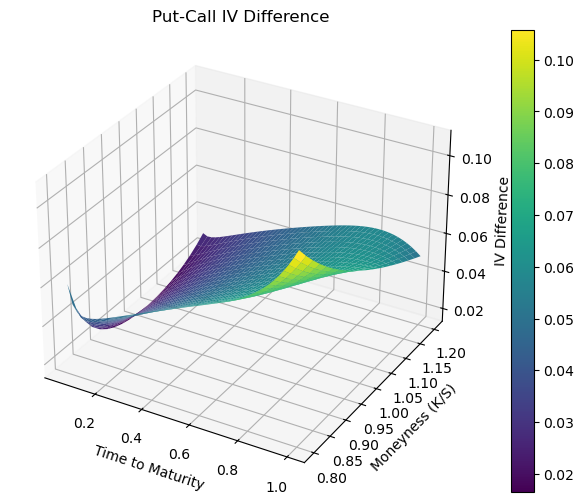

In [229]:
def check_put_call_parity(strikes, times, iv_surface_call, iv_surface_put):
    max_deviation = np.max(np.abs(iv_surface_call - iv_surface_put))
    mean_deviation = np.mean(np.abs(iv_surface_call - iv_surface_put))
    
    print("\nPut-Call Parity Check:")
    print(f"Maximum IV deviation: {max_deviation:.6f}")
    print(f"Mean IV deviation: {mean_deviation:.6f}")
    
    # Plot deviation surface
    plt.figure(figsize=(10, 6))
    ax = plt.axes(projection='3d')
    surf = ax.plot_surface(X, Y, np.abs(iv_surface_call - iv_surface_put), 
                          cmap='viridis')
    plt.colorbar(surf)
    ax.set_xlabel('Time to Maturity')
    ax.set_ylabel('Moneyness (K/S)')
    ax.set_zlabel('IV Difference')
    ax.set_title('Put-Call IV Difference')
    plt.show()

check_put_call_parity(strikes, times, iv_surface_call, iv_surface_put)

In [238]:
def calculate_option_price_uncertainty(Para, S0, K, T, r, n_samples=1000):
    # Get posterior samples from all chains
    posterior_samples = az.extract(Para).to_dataframe()
    
    call_prices = []
    put_prices = []
    
    # Use random samples from the posterior
    sample_indices = np.random.choice(len(posterior_samples), n_samples)
    
    for idx in sample_indices:
        c, p = merton_jump_diffusion(
            S0, K, T, r,
            posterior_samples['sigma'].iloc[idx],
            posterior_samples['lambda'].iloc[idx],  # Changed from lambda_ to lambda
            posterior_samples['mu_J'].iloc[idx],
            posterior_samples['sigma_J'].iloc[idx]
        )
        call_prices.append(c)
        put_prices.append(p)
    
    uncertainty_results = {
        'Call Mean': np.mean(call_prices),
        'Call Std': np.std(call_prices),
        'Call 5%': np.percentile(call_prices, 5),
        'Call 95%': np.percentile(call_prices, 95),
        'Put Mean': np.mean(put_prices),
        'Put Std': np.std(put_prices),
        'Put 5%': np.percentile(put_prices, 5),
        'Put 95%': np.percentile(put_prices, 95)
    }
    
    # Also create distributions plot
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(call_prices, bins=50, density=True, alpha=0.7)
    plt.title('Call Option Price Distribution')
    plt.xlabel('Price')
    plt.ylabel('Density')
    
    plt.subplot(1, 2, 2)
    plt.hist(put_prices, bins=50, density=True, alpha=0.7)
    plt.title('Put Option Price Distribution')
    plt.xlabel('Price')
    plt.ylabel('Density')
    
    plt.tight_layout()
    plt.show()
    
    return uncertainty_results


Option Price Uncertainty for Different Moneyness Levels (1-week maturity):

Moneyness = 0.9 (K = $320.26):


/var/folders/8d/cgrbd3xs3m97xzpgj1zs6j1m0000gn/T/ipykernel_8300/1361803505.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  poisson_weight = np.exp(-lam * T) * (lam * T)**k / np.math.factorial(k)


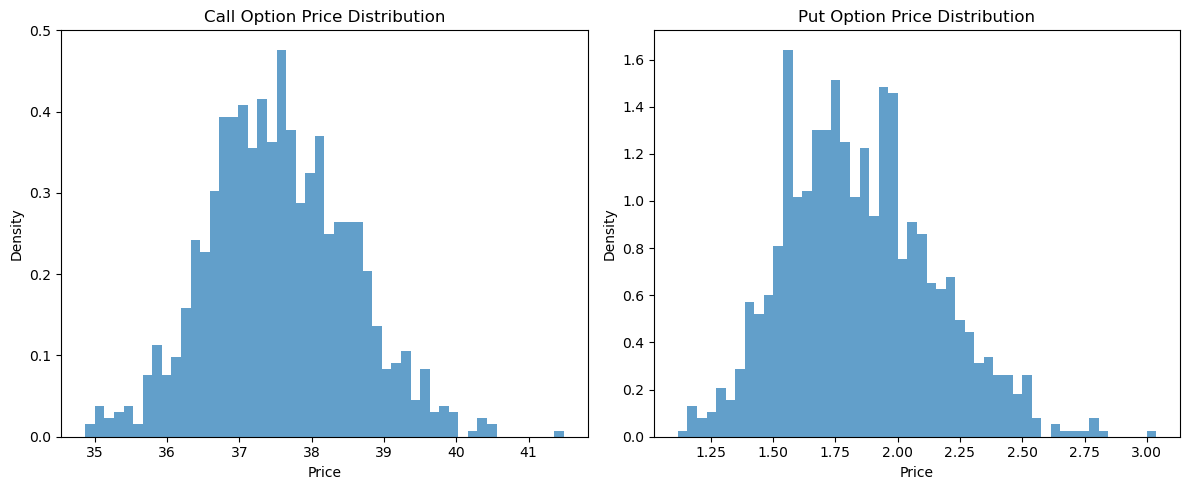

Call Mean: 37.55
Call Std: 0.98
Call 5%: 35.99
Call 95%: 39.26
Put Mean: 1.85
Put Std: 0.30
Put 5%: 1.41
Put 95%: 2.38

Moneyness = 1.0 (K = $355.84):


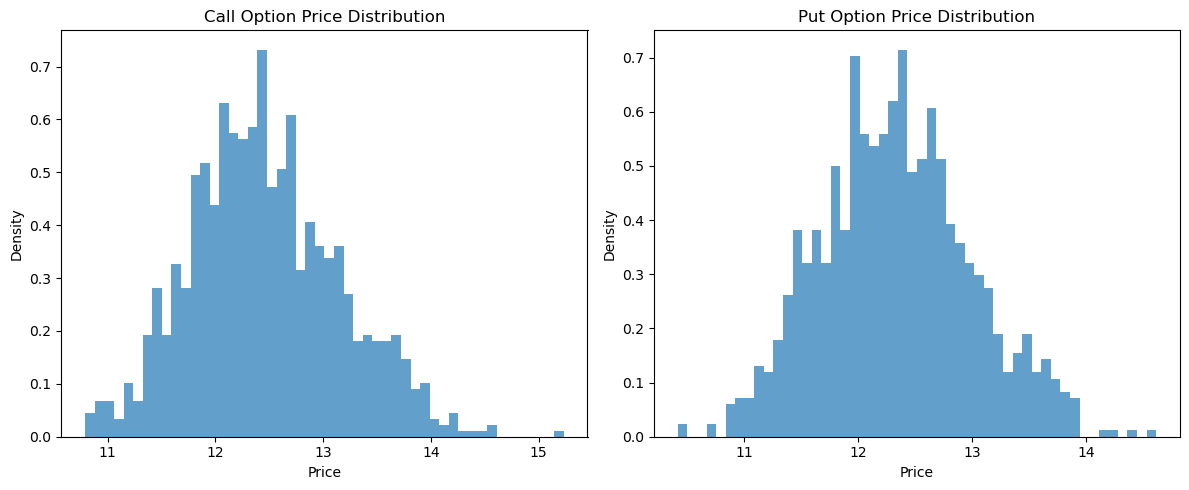

Call Mean: 12.46
Call Std: 0.69
Call 5%: 11.40
Call 95%: 13.68
Put Mean: 12.33
Put Std: 0.66
Put 5%: 11.31
Put 95%: 13.51

Moneyness = 1.1 (K = $391.42):


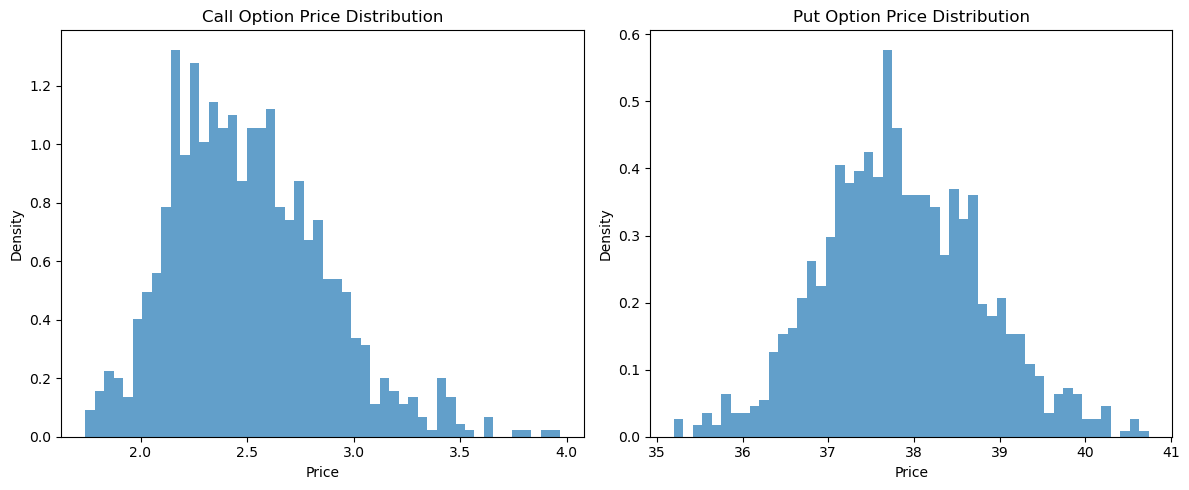

Call Mean: 2.51
Call Std: 0.36
Call 5%: 2.00
Call 95%: 3.16
Put Mean: 37.86
Put Std: 0.93
Put 5%: 36.42
Put 95%: 39.42


In [236]:
moneyness_levels = [0.9, 1.0, 1.1]
print("\nOption Price Uncertainty for Different Moneyness Levels (1-week maturity):")
for moneyness in moneyness_levels:
    K = S0 * moneyness
    print(f"\nMoneyness = {moneyness:.1f} (K = ${K:.2f}):")
    uncertainty = calculate_option_price_uncertainty(Para, S0, K, 1/52, r)
    for key, value in uncertainty.items():
        print(f"{key}: {value:.2f}")